### The purpose of this notebook is to complete a data cleaning workflow from start to finish in order to validate the core functionality our package

#### TO DO:
- Add in complete PubChem data
- Write PubChem function
- Organize code modules & tests
- Clean up/finish writing tests
- Write main script wrapper function


In [3]:
# imports
#rdkit imports
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFMCS
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

#housekeeping imports

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

all enzymes df with all known reactions
promiscuous enzymes df with all promiscuous reactions (pos and neg)
should we combine the kegg data and the metacyc data and see if that gives us more reactions? (future problem!)

1) filter and select all promiscuous pos and neg reactions into one dataframe
2) binarize that dataframe
3) write code to check whether a transformation exists
4) take binarized info and test out different models on it
make model with promiscuous enzymes
write code to check whether a transformation exists first, then puts the molecule through the model if necessary

## Step 8

#### Pre-process negative and positive datasets to remove rows with only 1 enzyme
Positive and negative data must be processed separately, as the average molecular distances will be calculated separately for each dataset

In [50]:
all_pos = pd.read_csv('../../../big-datasets/pos-with-dist-promlabel.csv')
neg = pd.read_csv('../../../big-datasets/neg-with-dist-promlabel.csv')

In [51]:
prom_pos = all_pos[all_pos['Promiscuous'] == 1]

In [52]:
prom_neg = neg[neg['Promiscuous'] == 1]

In [53]:
print(all_pos.shape, neg.shape, prom_pos.shape, prom_neg.shape)

(7395, 18) (9616, 18) (3777, 18) (7690, 18)


In [79]:
prom = pd.concat((prom_pos,prom_neg), axis=0)

TypeError: concat() got an unexpected keyword argument 'set_index'

In [80]:
prom = prom.drop(columns='Unnamed: 0')
prom.shape

(11467, 17)

In [81]:
prom.head()

,enzyme,product,reacts,PubChemID,SMILES,n_C,n_H,Fingerprint,n_O,n_N,n_P,n_S,n_X,n_DoU,MW,Dist,Promiscuous
1,EC-1.14.14.80,CPD-10515,1.0,25201835,CCCCCCCCC(C(CCCCCCCC(=O)[O-])O)O,18,35,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,4,0,0,0,0,1,315.474,0.714718,1.0
2,EC-1.14.14.80,PALMITATE,1.0,504166,CCCCCCCCCCCCCCCC(=O)[O-],16,31,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,0,0,0,1,255.422,0.714718,1.0
3,EC-1.14.14.80,OLEATE-CPD,1.0,5460221,CCCCCCCCC=CCCCCCCCC(=O)[O-],18,33,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,0,0,0,2,281.460,0.714718,1.0
4,EC-1.14.14.80,STEARIC_ACID,1.0,3033836,CCCCCCCCCCCCCCCCCC(=O)[O-],18,35,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,0,0,0,1,283.476,0.714718,1.0
5,EC-1.14.14.80,CPD-10514,1.0,19746553,CCCCCCCCC1C(O1)CCCCCCCC(=O)[O-],18,33,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3,0,0,0,0,2,297.459,0.714718,1.0


## Step 10
#### Get dummy variables to represent enzyme class
We expect that many enzyme properties could be predictive features for this model. Enzyme class should encapsulate many of these features at a high level.

In [29]:
def binarize_enzyme_class(dataframe, column):
    """
    binarize_enzyme_class() converts the enzyme class into binary dummy variables
        that are appended onto the input dataframe

    Args:
        dataframe (pandas.DataFrame): input dataset
        column (str): column name containing kegg enzyme id

    Returns:
        pandas.DataFrame: with seven columns appended for the seven enzyme classes
    """
    dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
    dataframe = pd.get_dummies(dataframe, columns=['enzyme_class'])
    return dataframe

In [86]:
import re
def strip_ec(df, ec_colname):
    
    stripped = []
    non_decimal = re.compile(r'[^\d.]+')
    for index, row in df.iterrows():
        target = row[ec_colname]
        fixed = non_decimal.sub('', target)
        stripped.append(fixed)
     
    df = df.drop(columns=ec_colname)
    df.insert(0,'Enzyme',stripped)
    
    
    return df

In [91]:
small = prom.iloc[:10,:].copy()

In [93]:
small.head(10)

,enzyme,product,reacts,PubChemID,SMILES,n_C,n_H,Fingerprint,n_O,n_N,n_P,n_S,n_X,n_DoU,MW,Dist,Promiscuous
1,EC-1.14.14.80,CPD-10515,1.0,25201835,CCCCCCCCC(C(CCCCCCCC(=O)[O-])O)O,18,35,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,4,0,0,0,0,1,315.474,0.714718,1.0
2,EC-1.14.14.80,PALMITATE,1.0,504166,CCCCCCCCCCCCCCCC(=O)[O-],16,31,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,0,0,0,1,255.422,0.714718,1.0
3,EC-1.14.14.80,OLEATE-CPD,1.0,5460221,CCCCCCCCC=CCCCCCCCC(=O)[O-],18,33,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,0,0,0,2,281.460,0.714718,1.0
4,EC-1.14.14.80,STEARIC_ACID,1.0,3033836,CCCCCCCCCCCCCCCCCC(=O)[O-],18,35,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,0,0,0,1,283.476,0.714718,1.0
5,EC-1.14.14.80,CPD-10514,1.0,19746553,CCCCCCCCC1C(O1)CCCCCCCC(=O)[O-],18,33,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3,0,0,0,0,2,297.459,0.714718,1.0
14,EC-2.7.7.81,CTP,1.0,7058166,C1=CN(C(=O)N=C1N)C2C(C(C(O2)COP(=O)([O-])OP(=O...,9,12,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,14,3,3,0,0,7,479.124,0.290483,1.0
15,EC-2.7.7.81,CPD-13166,1.0,70678926,CC(C(C1C(C(CC(O1)(C(=O)[O-])O)O)NC(=O)C)NC(=O)C)O,13,21,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,8,2,0,0,0,4,333.317,0.290483,1.0
20,EC-1.1.1.393,CPD-12451,1.0,20848964,CC(CCC(=O)[O-])C1CCC2C1(C(CC3C2C(CC4C3(CCC(C4)...,24,39,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,5,0,0,0,0,5,407.571,0.686074,1.0
21,EC-1.1.1.393,CPD-18796,1.0,20848971,CC(CCC(=O)[O-])C1CCC2C1(C(CC3C2CCC4C3(CCC(C4)O...,24,39,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,4,0,0,0,0,5,391.572,0.686074,1.0
22,EC-1.1.1.393,CPD-13677,1.0,122706120,CC(CCC(=O)[O-])C1CCC2C1(C(=O)CC3C2C(=O)CC4C3(C...,24,35,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,5,0,0,0,0,7,403.539,0.686074,1.0


In [94]:
attempted = strip_ec(small, 'enzyme')

In [96]:
attempted.head(10)

,Enzyme,product,reacts,PubChemID,SMILES,n_C,n_H,Fingerprint,n_O,n_N,n_P,n_S,n_X,n_DoU,MW,Dist,Promiscuous
1,1.14.14.80,CPD-10515,1.0,25201835,CCCCCCCCC(C(CCCCCCCC(=O)[O-])O)O,18,35,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,4,0,0,0,0,1,315.474,0.714718,1.0
2,1.14.14.80,PALMITATE,1.0,504166,CCCCCCCCCCCCCCCC(=O)[O-],16,31,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,0,0,0,1,255.422,0.714718,1.0
3,1.14.14.80,OLEATE-CPD,1.0,5460221,CCCCCCCCC=CCCCCCCCC(=O)[O-],18,33,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,0,0,0,2,281.460,0.714718,1.0
4,1.14.14.80,STEARIC_ACID,1.0,3033836,CCCCCCCCCCCCCCCCCC(=O)[O-],18,35,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,0,0,0,1,283.476,0.714718,1.0
5,1.14.14.80,CPD-10514,1.0,19746553,CCCCCCCCC1C(O1)CCCCCCCC(=O)[O-],18,33,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3,0,0,0,0,2,297.459,0.714718,1.0
14,2.7.7.81,CTP,1.0,7058166,C1=CN(C(=O)N=C1N)C2C(C(C(O2)COP(=O)([O-])OP(=O...,9,12,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,14,3,3,0,0,7,479.124,0.290483,1.0
15,2.7.7.81,CPD-13166,1.0,70678926,CC(C(C1C(C(CC(O1)(C(=O)[O-])O)O)NC(=O)C)NC(=O)C)O,13,21,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,8,2,0,0,0,4,333.317,0.290483,1.0
20,1.1.1.393,CPD-12451,1.0,20848964,CC(CCC(=O)[O-])C1CCC2C1(C(CC3C2C(CC4C3(CCC(C4)...,24,39,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,5,0,0,0,0,5,407.571,0.686074,1.0
21,1.1.1.393,CPD-18796,1.0,20848971,CC(CCC(=O)[O-])C1CCC2C1(C(CC3C2CCC4C3(CCC(C4)O...,24,39,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,4,0,0,0,0,5,391.572,0.686074,1.0
22,1.1.1.393,CPD-13677,1.0,122706120,CC(CCC(=O)[O-])C1CCC2C1(C(=O)CC3C2C(=O)CC4C3(C...,24,35,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,5,0,0,0,0,7,403.539,0.686074,1.0


In [97]:
prom_stripped = strip_ec(prom, 'enzyme')

In [99]:
prom_stripped.head(10)

,Enzyme,product,reacts,PubChemID,SMILES,n_C,n_H,Fingerprint,n_O,n_N,n_P,n_S,n_X,n_DoU,MW,Dist,Promiscuous
1,1.14.14.80,CPD-10515,1.0,25201835,CCCCCCCCC(C(CCCCCCCC(=O)[O-])O)O,18,35,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,4,0,0,0,0,1,315.474,0.714718,1.0
2,1.14.14.80,PALMITATE,1.0,504166,CCCCCCCCCCCCCCCC(=O)[O-],16,31,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,0,0,0,1,255.422,0.714718,1.0
3,1.14.14.80,OLEATE-CPD,1.0,5460221,CCCCCCCCC=CCCCCCCCC(=O)[O-],18,33,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,0,0,0,2,281.460,0.714718,1.0
4,1.14.14.80,STEARIC_ACID,1.0,3033836,CCCCCCCCCCCCCCCCCC(=O)[O-],18,35,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,0,0,0,1,283.476,0.714718,1.0
5,1.14.14.80,CPD-10514,1.0,19746553,CCCCCCCCC1C(O1)CCCCCCCC(=O)[O-],18,33,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3,0,0,0,0,2,297.459,0.714718,1.0
14,2.7.7.81,CTP,1.0,7058166,C1=CN(C(=O)N=C1N)C2C(C(C(O2)COP(=O)([O-])OP(=O...,9,12,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,14,3,3,0,0,7,479.124,0.290483,1.0
15,2.7.7.81,CPD-13166,1.0,70678926,CC(C(C1C(C(CC(O1)(C(=O)[O-])O)O)NC(=O)C)NC(=O)C)O,13,21,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,8,2,0,0,0,4,333.317,0.290483,1.0
20,1.1.1.393,CPD-12451,1.0,20848964,CC(CCC(=O)[O-])C1CCC2C1(C(CC3C2C(CC4C3(CCC(C4)...,24,39,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,5,0,0,0,0,5,407.571,0.686074,1.0
21,1.1.1.393,CPD-18796,1.0,20848971,CC(CCC(=O)[O-])C1CCC2C1(C(CC3C2CCC4C3(CCC(C4)O...,24,39,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,4,0,0,0,0,5,391.572,0.686074,1.0
22,1.1.1.393,CPD-13677,1.0,122706120,CC(CCC(=O)[O-])C1CCC2C1(C(=O)CC3C2C(=O)CC4C3(C...,24,35,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,5,0,0,0,0,7,403.539,0.686074,1.0


In [101]:
# binarize_enzyme_class()

master_df = binarize_enzyme_class(prom_stripped, 'Enzyme')

#master_df_df = master_df.reset_index(drop=True)
#print(master_df.shape)
master_df.head(20)

,Enzyme,product,reacts,PubChemID,SMILES,n_C,n_H,Fingerprint,n_O,n_N,...,MW,Dist,Promiscuous,enzyme_class_1,enzyme_class_2,enzyme_class_3,enzyme_class_4,enzyme_class_5,enzyme_class_6,enzyme_class_7
1,1.14.14.80,CPD-10515,1.0,25201835,CCCCCCCCC(C(CCCCCCCC(=O)[O-])O)O,18,35,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,4,0,...,315.474,0.714718,1.0,1,0,0,0,0,0,0
2,1.14.14.80,PALMITATE,1.0,504166,CCCCCCCCCCCCCCCC(=O)[O-],16,31,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,...,255.422,0.714718,1.0,1,0,0,0,0,0,0
3,1.14.14.80,OLEATE-CPD,1.0,5460221,CCCCCCCCC=CCCCCCCCC(=O)[O-],18,33,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,...,281.460,0.714718,1.0,1,0,0,0,0,0,0
4,1.14.14.80,STEARIC_ACID,1.0,3033836,CCCCCCCCCCCCCCCCCC(=O)[O-],18,35,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2,0,...,283.476,0.714718,1.0,1,0,0,0,0,0,0
5,1.14.14.80,CPD-10514,1.0,19746553,CCCCCCCCC1C(O1)CCCCCCCC(=O)[O-],18,33,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3,0,...,297.459,0.714718,1.0,1,0,0,0,0,0,0
14,2.7.7.81,CTP,1.0,7058166,C1=CN(C(=O)N=C1N)C2C(C(C(O2)COP(=O)([O-])OP(=O...,9,12,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,14,3,...,479.124,0.290483,1.0,0,1,0,0,0,0,0
15,2.7.7.81,CPD-13166,1.0,70678926,CC(C(C1C(C(CC(O1)(C(=O)[O-])O)O)NC(=O)C)NC(=O)C)O,13,21,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,8,2,...,333.317,0.290483,1.0,0,1,0,0,0,0,0
20,1.1.1.393,CPD-12451,1.0,20848964,CC(CCC(=O)[O-])C1CCC2C1(C(CC3C2C(CC4C3(CCC(C4)...,24,39,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,5,0,...,407.571,0.686074,1.0,1,0,0,0,0,0,0
21,1.1.1.393,CPD-18796,1.0,20848971,CC(CCC(=O)[O-])C1CCC2C1(C(CC3C2CCC4C3(CCC(C4)O...,24,39,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,4,0,...,391.572,0.686074,1.0,1,0,0,0,0,0,0
22,1.1.1.393,CPD-13677,1.0,122706120,CC(CCC(=O)[O-])C1CCC2C1(C(=O)CC3C2C(=O)CC4C3(C...,24,35,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,5,0,...,403.539,0.686074,1.0,1,0,0,0,0,0,0


In [102]:
master_df.shape

(11467, 24)

In [4]:
master_df = pd.read_csv('../../../big-datasets/master_dataframe_metacyc.csv')

In [6]:
master_df.to_csv('../../../big-datasets/master_dataframe_metacyc.csv.gz', index=None, compression='gzip')

## Out of curiosity:
#### Examine average molecular distance distributions for negative and positive data
On first glance, it appears that our hypothesis is correct in that the distributions of average molecular distances are qualitatively different between the positive and negative datasets

AttributeError: Unknown property figsize

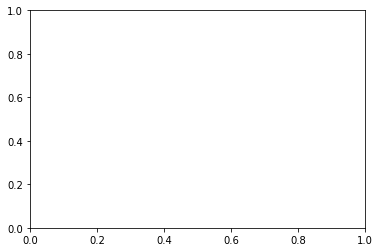

In [20]:
# look at distributions of distances for positive and negative data

#fig, axes = plt(1, 1, figsize=(9, 5))
fig, axes = plt.plot(1, 1, figsize=(9, 5))

pos = sns.distplot(pos_dist_df['dist'], bins=90, kde=True, norm_hist=True, ax=axes[0], color= 'red')
axes[0].set_title('Avg. Tanimoto Similarity to Positive Prediction Products')

neg = sns.distplot(neg_dist_df['dist'], bins=30, kde=True, norm_hist=False, ax=axes[0])
axes[0].set_title('Avg. Tanimoto Similarity to Negative Prediction Products')

for axis in axes:
    axis.set_xlim([0.0, 1.0])
    
fig.savefig('output')

In [ ]:
pos_dist_df = prom_pos

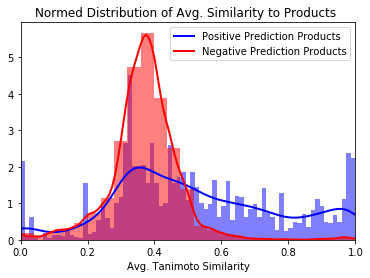

In [106]:
# look at distributions of distances for positive and negative data
pos_dist = pd.Series(prom_pos['Dist'], name="Avg. Tanimoto Similarity")
neg_dist = pd.Series(prom_neg['Dist'], name="Avg. Tanimoto Similarity")

fig = sns.distplot(pos_dist, bins=75, kde=True,
                   kde_kws={"color": "b", "lw": 2, "label": "Positive Prediction Products"},
                   hist_kws={"histtype": "bar", "linewidth": 3, "alpha": 0.5, "color": "b"})

fig.set_xlim([0.0, 1.0])
sns.distplot(neg_dist, bins=25, kde=True,
                   kde_kws={"color": "r", "lw": 2, "label": "Negative Prediction Products"},
                   hist_kws={"histtype": "bar", "linewidth": 3, "alpha": 0.5, "color": "r"})
fig.set_title('Normed Distribution of Avg. Similarity to Products ')
plt.savefig('output')

In [ ]:
fig.savefig

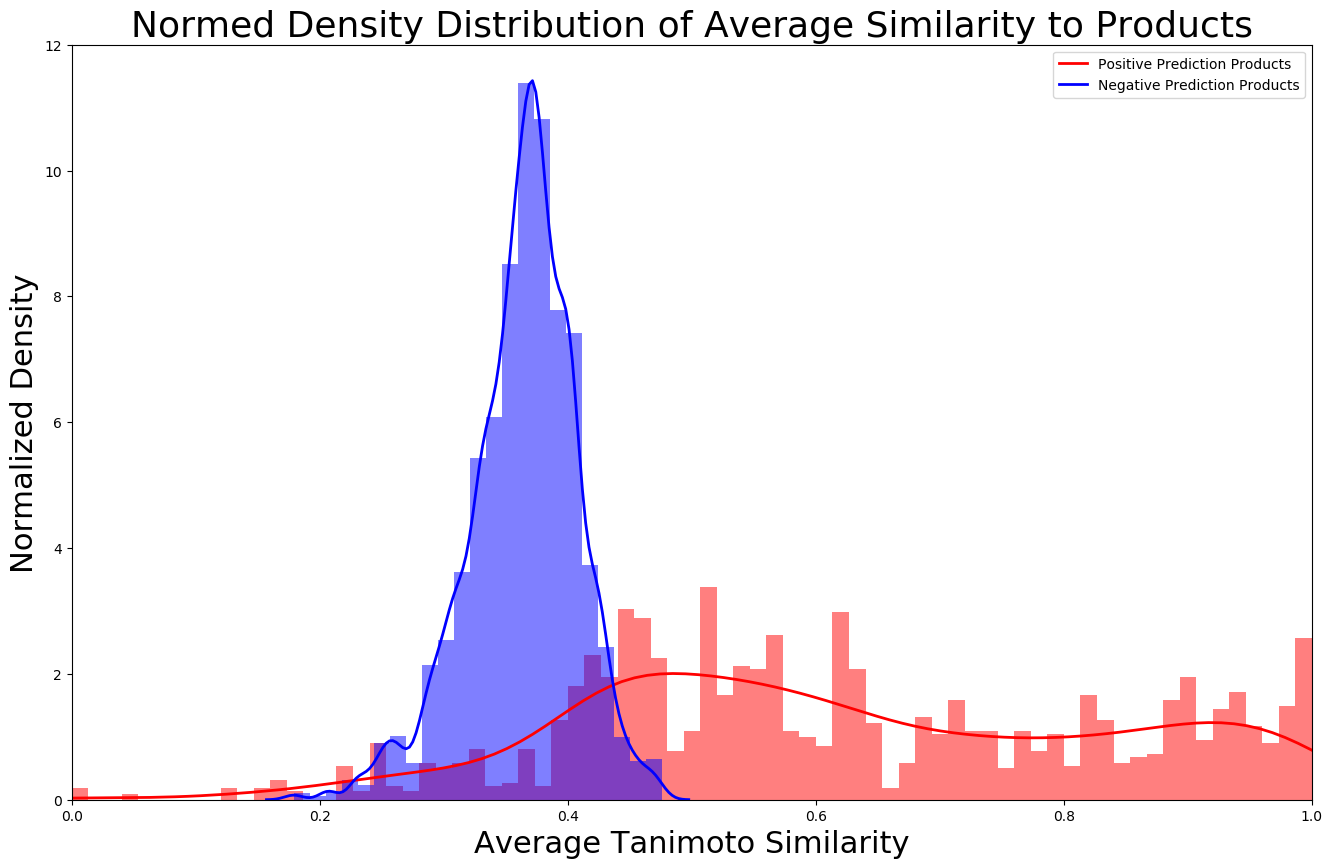

In [38]:
fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 100)
sns.distplot(pos_dist, ax=ax, bins=75, kde=True,
                   kde_kws={"color": "r", "lw": 2, "label": "Positive Prediction Products"},
                   hist_kws={"histtype": "bar", "linewidth": 3, "alpha": 0.5, "color": "r"})
ax.set_xlim([0.0, 1.0])
sns.distplot(neg_dist, ax=ax, bins=23, kde=True,
                   kde_kws={"color": "b", "lw": 2, "label": "Negative Prediction Products"},
                   hist_kws={"histtype": "bar", "linewidth": 3, "alpha": 0.5, "color": "b"})
ax.set_title('Normed Density Distribution of Average Similarity to Products', fontsize=26)
ax.set_xlabel('Average Tanimoto Similarity', fontsize=22)
ax.set_ylabel('Normalized Density', fontsize=22)
fig.savefig('output')